# Analysis of surface perturbations due to multiple obstacles

In this notebook, an analysis of free surface perturbations due to a submerged array of circular cylinders is conducted. The liquid moves around the cylinders with a characteristic velocity parameter called lambda. Disturbances in the surface are analysed via the slenderness parameter of the forming waves. Those waves for which the slenderness parameter is greater than 0.2 are classified as jetting. 

### Load data and create database

The surface perturbation for multiple obstacles will be computed as the superposition of perturbations due to single obstacles. The data for single obstacles is stored in the folder ./single_obstacle. There, matlab (*.mat)* files contain the spatio-temporal functions needed for compute the perturbations

In [1]:
# library imports
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import plotly.express as px
from Shot import Makarenko_Analysis, MultipleObstacleAnalysis
import plotly.io as pio
from scipy.signal import find_peaks, savgol_filter
from auxiliary_functions import compute_steepness, find_peaks, plot_surface_peaks
pio.renderers.default = 'notebook'

single_obstacle_folder = r'.\single_obstacle'
os.chdir(single_obstacle_folder)


# For lambda = 5
matlab_files = ['R0_10A0_10B0_10Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_20A0_20B0_20Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_30A0_30B0_30Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_40A0_40B0_40Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_50A0_50B0_50Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_60A0_60B0_60Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_70A0_70B0_70Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_80A0_80B0_80Lambda5_0XM20_0Dx0_2Zc1N8.mat',
                'R0_90A0_90B0_90Lambda5_0XM20_0Dx0_2Zc1N8.mat'                
               ]
lambd = 5

# For lambda = 0.1
matlab_files = ['R0_10A0_10B0_10Lambda0_1XM20_0Dx0_2Zc1N8.mat',
                #'R0_20A0_20B0_20Lambda0_1XM20_0Dx0_2Zc1N9.mat',
                'R0_30A0_30B0_30Lambda0_1XM10_0Dx0_1Zc1N8.mat',
                #'R0_40A0_40B0_40Lambda0_1XM20_0Dx0_1Zc1N8.mat',
                'R0_50A0_50B0_50Lambda0_1XM20_0Dx0_1Zc1N8.mat',
                #'R0_60A0_60B0_60Lambda0_1XM20_0Dx0_1Zc1N8.mat',
                'R0_70A0_70B0_70Lambda0_1XM20_0Dx0_1Zc1N8.mat',
                #'R0_80A0_80B0_80Lambda0_1XM20_0Dx0_1Zc1N8.mat',
                'R0_90A0_90B0_90Lambda0_1XM10_0Dx0_1Zc1N8.mat'                
               ]
matlab_files = ['R0_90A0_90B0_90Lambda0_1XM10_0Dx0_1Zc1N8.mat',
             'R0_70A0_70B0_70Lambda0_1XM20_0Dx0_1Zc1N8.mat',
             'R0_50A0_50B0_50Lambda0_1XM20_0Dx0_1Zc1N8.mat',
             'R0_30A0_30B0_30Lambda0_1XM10_0Dx0_1Zc1N8.mat',
             'R0_10A0_10B0_10Lambda0_1XM20_0Dx0_2Zc1N8.mat']
lambd = 0.1


# For lambda = 1
matlab_files = ['R0_90A0_90B0_90Lambda1_0XM20_0Dx0_2Zc1N8.mat',
             'R0_80A0_80B0_80Lambda1_0XM40_0Dx0_2Zc1N8.mat',
             'R0_70A0_70B0_70Lambda1_0XM20_0Dx0_2Zc1N8.mat',
             'R0_60A0_60B0_60Lambda1_0XM20_0Dx0_2Zc1N8.mat',
             'R0_50A0_50B0_50Lambda1_0XM40_0Dx0_2Zc1N8.mat',
             'R0_40A0_40B0_40Lambda1_0XM10_0Dx0_1Zc1N8.mat',
             'R0_30A0_30B0_30Lambda1_0XM20_0Dx0_2Zc1N8.mat',
             'R0_20A0_20B0_20Lambda1_0XM20_0Dx0_1Zc1N8.mat',
             'R0_10A0_10B0_10Lambda1_0XM20_0Dx0_2Zc1N8.mat']
lambd =1

Below, a diagram of the system geometry and relevant dimensional and nondimensional variables is shown. Take note of the three relevant nondimensional groups: the relative initial depth of the mesh d*, the relative periodicity of the mesh m* and the inverse squared Froud number lambda. In this notebook we will only make a parametric analyisis of the first two, keeping lambda constant. We will study how the slenderness s of central and lateral waves evolve as m* and d* is changed.

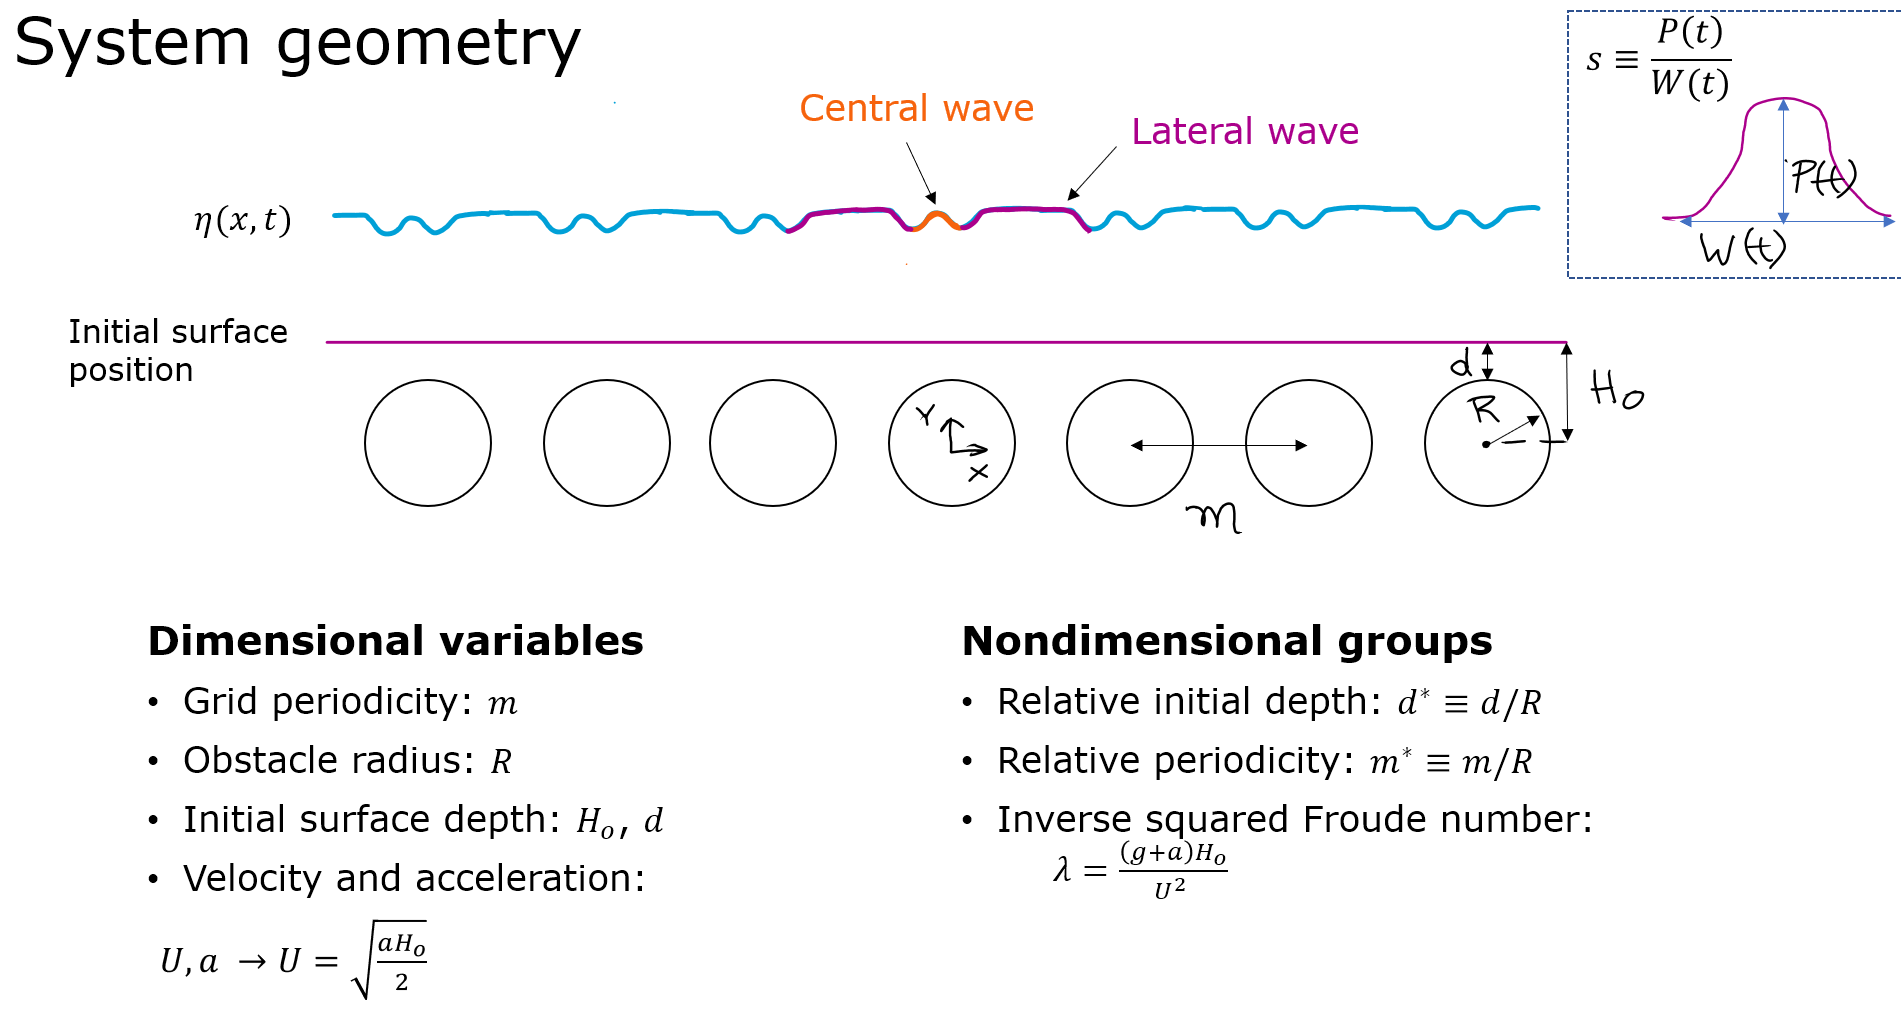

We are going to place 11 obstacles to simulate an infinity array, which would be more accurate when analysing
perturbations around x = 0. Let's create a dataframe containing the info about perturbations.

In [2]:
r_range = np.array([0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])
d_range = np.round((1/r_range -1)*100)/100
separation_factor_range = np.array([3,4,5,6,7,8,9,10])
t_aster_range = np.linspace(0,1.2,60)
x_range = np.linspace(-10,10,1000)
index = pd.MultiIndex.from_product([d_range,separation_factor_range, t_aster_range,x_range], names =('d*','m*','t*','x*'))

Then read the perturbation amplitude for each d*, m and t* from the single obstacle matlab files

In [3]:
analysis = MultipleObstacleAnalysis()
analysis.set_no_of_obstacles(21)
df = pd.DataFrame({'eta': pd.Series(dtype='float')},index=index )
for r_aster, d_aster, file in zip(r_range, d_range, matlab_files):    
    analysis.read_matlab_file(file)
    analysis.set_x_vals(x_range)
    for separation_factor in separation_factor_range:
        analysis.set_separation(separation_factor * r_aster)
        for t_aster in t_aster_range:            
            df.loc[d_aster,separation_factor,t_aster]['eta'] = analysis.eta(t_aster=t_aster,
                                                                            highest_order=8, smooth_window_size = 11)
df = df.reset_index()

### Plot surface perturbations for different d*, m* and t*

In [4]:
fig1 = px.line(df.loc[df['t*']==t_aster_range[-1] ], x = 'x*', y = 'eta', range_y=[-1,1],range_x=[-5,5], facet_col = 'd*',
              facet_row ='m*', title='Multiple obstacle surface perturbation',facet_row_spacing = 0.05,
               width = 1000, height = 800,)

fig1.show()
#os.chdir(plots_folder)
#fig1.write_html(f'surface_perturbations_lambd_{lambd}.html')

### Divide  surface into central and lateral zones

In [5]:
# Function to plot the multiple peaks accross time

from auxiliary_functions import test_surface_peaks
def plot_surface_peaks(df, m_factor, d_aster, x):
    fig = go.Figure()
    t_aster_range = df['t*'].unique()
    for t_aster in t_aster_range:
        y = df[(df['m*'] == m_factor) & (df['d*'] == d_aster) & (df['t*'] == t_aster)]['eta'].values
        r_aster = 1/(1+d_aster)
        fig_step = test_surface_peaks(x, y, m_factor * r_aster)
        for d in fig_step.data:
            fig.add_trace(d)
    steps = []
    for i in range(0, len(fig.data), len(fig_step.data)):
        step = dict(
            method="restyle",
            args=["visible", [False] * len(fig.data)],
        )
        step["label"] = "{:.2f}".format(t_aster_range[int(i / len(fig_step.data))])
        for j in range(len(fig_step.data)):
            step["args"][1][i + j] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    for j in range(len(fig_step.data)):
        fig.data[j].visible = True  # Toggle i'th trace to "visible"
    sliders = [dict(active=10, steps=steps, )]
    fig.layout.update(
        yaxis_range=[-0.5, 0.5],
        xaxis_title=r'$x$',
        yaxis_title=r'$\eta$',
        sliders=sliders)
    return fig

In [6]:
# TODO: plot a symetrical plot between -m and m
# TODO: create functions for all the sections of this notebook
# parameters to test:
m_factor = 4
d_aster = 0.43
x=x_range
fig = plot_surface_peaks(df, m_factor, d_aster, x)    
fig.show()
#fig.write_html(f'perturbation_regions_lambd_{lambd}.html')

### Compute steepness of both depression wave and central wave.

In [7]:
central_df = df[['m*','d*','t*']].drop_duplicates().reset_index(drop = True)
central_df['s'] = np.NaN
lateral_df = central_df.copy()
overall_df = central_df.copy()


for m_factor in df['m*'].unique():
    for d in df['d*'].unique():
        for t in df['t*'].unique():
            filtr = (df['m*'] == m_factor) & (df['d*'] == d)  &  (df['t*'] == t)
            x = df.loc[filtr,'x*']
            eta = df.loc[filtr, 'eta'] 
            r = 1/(1+d)
            s_central, s_depression = compute_steepness(x.values, eta.values, m_factor*r) 
            
            filtr = (central_df['m*'] == m_factor) & (central_df['d*'] == d)  &  (central_df['t*'] == t)
            central_df.loc[filtr,'s'] = s_depression
            lateral_df.loc[filtr,'s'] = s_central
            overall_df.loc[filtr,'s'] = max(s_depression,s_central)


In [8]:
d = {'Central': central_df, 'Lateral': lateral_df, 'Overall': overall_df }
steepness_df = pd.concat(d.values(), keys = d.keys())
steepness_df = steepness_df.rename_axis(index=['Region', 'id']).reset_index(level='Region')

In [9]:
# create auxiliar dataframe with steepness of central and lateral side by side
aux = steepness_df[steepness_df['Region'] == 'Lateral']
aux = aux.rename(columns={'s':'s_lateral'})
aux['s_central'] = steepness_df[steepness_df['Region'] == 'Central'].s.values
fig2 = px.line(aux, x = 't*', y = ['s_central','s_lateral'],  facet_col = 'd*', facet_row = 'm*',
                  width = 1000, height =800, facet_row_spacing = 0.05, range_y = [0,0.5])
fig2.show()
#fig2.write_html(f'surface_steepness_{lambd}.html')

### Classify central and lateral perturbations according to steepness value at t* = 1

In [10]:
def classify_perturbation(row,  threshold = 0.2):   
    ### Exception so that Jetting and Gravity waves are at all times
    if (row['d*']== d_range[0]):
        return 'Jetting'
    if row['s'] == np.NaN:
        return 'Gravity Wave'
    if row['s'] >= threshold:
        return 'Jetting'
    return 'Gravity wave'

In [11]:
steepness_df['Classification'] = steepness_df.apply (lambda row: classify_perturbation(row, threshold = 0.18), axis=1) 
fig3 = px.scatter(steepness_df.loc[steepness_df['t*']==t_aster_range[-1] ] , animation_frame = 't*', x = 'd*', y = 'm*', color = 'Classification',
                  facet_col = 'Region', log_x = True)    
fig3.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),)
fig3.show()

This phase map allows for designing submerged meshes such that the surface remains smooth through th